## **Importing libraries**

In [87]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from sklearn.pipeline import Pipeline
from skimage import color, transform
from sklearn.preprocessing import FunctionTransformer
from PIL import Image
from pathlib import Path

## Verifying the GPU Setup [tensorflow + CUDA (Compute Unified Device Architecture) => Let's you use GPU for Computation other than Graphics]

In [88]:
# !python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

## **Data Preprocessing**
#### Used *'https://youtube.com/playlist?list=PLvz5lCwTgdXDNcXEVwwHsb9DwjNXZGsoy&si=gPCwVkKpS63FVLAC'* for guidance

# Training Image Preprocessing

In [89]:
curr_dir = os.getcwd()

In [90]:
training_set = tf.keras.utils.image_dataset_from_directory(
    './data/PlantVillage_Cleaned/split_data/train',
    labels="inferred", # leaving inferred, keras generates labels and class name automatically i.e.,
    # [Pepper_mold, Potato_healthy, Tomato_healthy, ...] alphabetically, where labels [0, 1, 2, ...]
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=40,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)

Found 24652 files belonging to 15 classes.


## Validation Image Preprocessing

In [91]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    './data/PlantVillage_Cleaned/split_data/valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=40,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)

Found 5278 files belonging to 15 classes.


In [92]:
for x, y in training_set:
    print(x, x.shape)
    print(y, y.shape)
    break

tf.Tensor(
[[[[  0.     0.     0.  ]
   [  0.     0.     0.  ]
   [  0.     0.     0.  ]
   ...
   [  0.     0.     0.  ]
   [  0.     0.     0.  ]
   [  0.     0.     0.  ]]

  [[  0.     0.     0.  ]
   [  0.     0.     0.  ]
   [  0.     0.     0.  ]
   ...
   [  0.     0.     0.  ]
   [  0.     0.     0.  ]
   [  0.     0.     0.  ]]

  [[  0.     0.     0.  ]
   [  0.     0.     0.  ]
   [  0.     0.     0.  ]
   ...
   [  0.     0.     0.  ]
   [  0.     0.     0.  ]
   [  0.     0.     0.  ]]

  ...

  [[  0.     0.     0.  ]
   [  0.     0.     0.  ]
   [  0.     0.     0.  ]
   ...
   [  0.     0.     0.  ]
   [  0.     0.     0.  ]
   [  0.     0.     0.  ]]

  [[  0.     0.     0.  ]
   [  0.     0.     0.  ]
   [  0.     0.     0.  ]
   ...
   [  0.     0.     0.  ]
   [  0.     0.     0.  ]
   [  0.     0.     0.  ]]

  [[  0.     0.     0.  ]
   [  0.     0.     0.  ]
   [  0.     0.     0.  ]
   ...
   [  0.     0.     0.  ]
   [  0.     0.     0.  ]
   [  0.     0.     

# **Building Model**

In [93]:
cnn = Sequential()

## Building Convolution Layers (Architecture)

In [94]:
# 🧠 CNN Concept Summary:

# 1️⃣ Each cnn.add() = one layer (Conv, Pool, etc.)
#     → Conv2D = learns features (edges → textures → shapes)
#     → MaxPool2D = downsamples feature maps (keeps strongest features)

# 2️⃣ Repeated Conv+Pool blocks = deeper understanding:
#     Block1: basic edges/colors
#     Block2: shapes/textures
#     Block3: complex leaf patterns
#     Block4: disease regions

# 3️⃣ Kernel (3x3): small filter sliding over input
#     → detects local patterns (like edge fragments)

# 4️⃣ padding='same': adds zero borders → output height & width stay same
#     padding='valid': no padding → output shrinks

# 5️⃣ input_shape: only needed in the first Conv2D layer
#     → later layers infer input size automatically

# 6️⃣ Max Pooling (2x2): reduces feature map size by half
#     → keeps key activations, adds translation invariance

# 7️⃣ Hierarchy summary:
#     Input → Conv → Pool → Conv → Pool → Flatten → Dense → Output


In [95]:
cnn.add(Conv2D(filters=32, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = [128,128, 3])) # input_size = [widht, height, input shape]
cnn.add(Conv2D(filters=32, kernel_size = 3, padding = 'same', activation = 'relu'))
cnn.add(MaxPool2D(pool_size = 2, strides = 2)) # pool size -> shape of pooling filter, strides -> movement of sliding window

/home/root123/GitHub/Two_Months_ML_Journey/Week 4/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [96]:
cnn.add(Conv2D(filters=64, kernel_size = 3, padding = 'same', activation = 'relu'))
cnn.add(Conv2D(filters=64, kernel_size = 3, padding = 'same', activation = 'relu'))
cnn.add(MaxPool2D(pool_size = 2, strides = 2))

In [97]:
cnn.add(Conv2D(filters=128, kernel_size = 3, padding = 'same', activation = 'relu'))
cnn.add(Conv2D(filters=128, kernel_size = 3, padding = 'same', activation = 'relu'))
cnn.add(MaxPool2D(pool_size = 2, strides = 2))

In [98]:
# cnn.add(Conv2D(filters=256, kernel_size = 3, padding = 'same', activation = 'relu'))
# cnn.add(Conv2D(filters=256, kernel_size = 3, padding = 'same', activation = 'relu'))
# cnn.add(MaxPool2D(pool_size = 2, strides = 2))

In [99]:
# Flattening the results to pass to the dense layer
cnn.add(Flatten())

In [100]:
cnn.add(Dense(units = 64, activation = 'relu'))

In [101]:
# output layer
cnn.add(Dense(units = 15, activation = 'softmax'))

## Compiling Model

In [102]:
cnn.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', Precision(), Recall()])

In [103]:
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,385,199 (9.10 MB)

 Trainable params: 2,385,199 (9.10 MB)

 Non-trainable params: 0 (0.00 B)

## Training Model

In [104]:
training_history = cnn.fit(x = training_set, validation_data = validation_set, epochs = 20)

Epoch 1/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 49s 59ms/step - accuracy: 0.7155 - loss: 1.0485 - precision_1: 0.8585 - recall_1: 0.6152 - val_accuracy: 0.8189 - val_loss: 0.5696 - val_precision_1: 0.8654 - val_recall_1: 0.7895
Epoch 2/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 43s 56ms/step - accuracy: 0.8728 - loss: 0.3881 - precision_1: 0.9099 - recall_1: 0.8398 - val_accuracy: 0.8757 - val_loss: 0.3694 - val_precision_1: 0.9034 - val_recall_1: 0.8558
Epoch 3/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 44s 58ms/step - accuracy: 0.9136 - loss: 0.2616 - precision_1: 0.9333 - recall_1: 0.8965 - val_accuracy: 0.9034 - val_loss: 0.3003 - val_precision_1: 0.9254 - val_recall_1: 0.8882
Epoch 4/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 44s 57ms/step - accuracy: 0.9414 - loss: 0.1736 - precision_1: 0.9515 - recall_1: 0.9333 - val_accuracy: 0.8666 - val_loss: 0.5263 - val_precision_1: 0.8753 - val_recall_1: 0.8594
Epoch 5/20
771/771 ━━━━━━━━━━━━━━━━━━━━ 44s 57ms/step - accuracy: 0.9481 - loss: 0.1531 - precision_1: 0.9545 - recall_1

## Model Evaluation

In [105]:
train_loss, train_acc, train_pre, train_rec = cnn.evaluate(training_set)

771/771 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.9937 - loss: 0.0203 - precision_1: 0.9939 - recall_1: 0.9936


In [106]:
print(train_loss, train_acc, train_pre, train_rec)

0.020252598449587822 0.9937124848365784 0.9939135909080505 0.9936313629150391


In [107]:
valid_loss, valid_acc, valid_pre, valid_rec = cnn.evaluate(validation_set)

165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9110 - loss: 0.5233 - precision_1: 0.9142 - recall_1: 0.9085


In [108]:
print(valid_loss, valid_acc, valid_pre, valid_rec)

0.5232720375061035 0.9109511375427246 0.9142040014266968 0.9084880352020264


## Accuracy Visualization

In [109]:
print(training_history.history['accuracy'])

[0.7154794931411743, 0.872789204120636, 0.9135972857475281, 0.9413840770721436, 0.9481177926063538, 0.9585834741592407, 0.9662501811981201, 0.9690086245536804, 0.9750121831893921, 0.9738357663154602, 0.9749715924263, 0.9758234620094299, 0.9795554280281067, 0.9784196019172668, 0.979920506477356, 0.9832062125205994, 0.9867353439331055, 0.9878305792808533, 0.9831656813621521, 0.985761821269989]


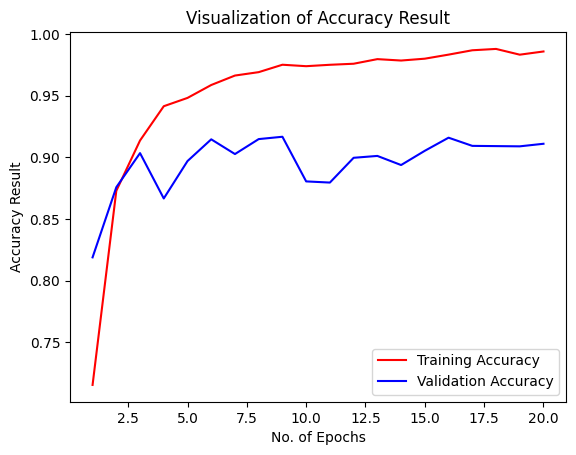

In [110]:
epochs = [i for i in range(1,21)]
plt.plot(epochs, training_history.history['accuracy'], color='red', label ='Training Accuracy')
plt.plot(epochs, training_history.history['val_accuracy'], color='blue', label ='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy Result')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

## Creating Pipeline

In [111]:
# creating a function transformer to pass it to pipeline

def preprocess(img):
    # Convert PIL Image → NumPy array
    if isinstance(img, Image.Image):
        img = np.array(img)
    # grayscale (no channel dimension)
    if img.ndim == 2:
        img = color.gray2rgb(img)
    # RGBA (4 channels)
    elif img.shape[2] == 4:
        img = color.rgba2rgb(img)

    # Resize to 128x128
    resized_img = transform.resize(img, (128, 128), anti_aliasing=True) # anti_aliasing makes img smoother when shrinked
    return resized_img

# converting our function to 'Function Transformer' for compatibility with Sklearn's pipeline
rgb_resize_transformer = FunctionTransformer(
    lambda imgs: np.array([preprocess(img) for img in imgs])
)

In [112]:
pipeline = Pipeline(steps=[
    ('preprocess', rgb_resize_transformer),
    ('model', cnn),
])

In [113]:
curr_dir

'/home/root123/GitHub/Two_Months_ML_Journey/Week 4'

In [123]:
destination_path = 'test_data'
predict_img_path = curr_dir/Path(destination_path)
predictions = [
    'Pepper Bell Bacterial Spot',
    'Pepper Bell Healthy',
    'Potato Early Blight',
    'Potato Healthy',
    'Potato Late Blight',
    'Tomato Target Spot',
    'Tomato Mosaic Virus',
    'Tomato Yellow Leaf Curl Virus',
    'Tomato Bacterial Spot',
    'Tomato Early Blight',
    'Tomato Healthy',
    'Tomato Late Blight',
    'Tomato Leaf Mold',
    'Tomato Septoria Leaf Spot',
    'Tomato Spider Mites',
]   


In [124]:
for img_file in predict_img_path.iterdir():
    if img_file.suffix.lower() in ['.jpg', '.png']:
        # Open image
        img = Image.open(img_file)
        
        # Run through your pipeline (wrap in list or array)
        pred = pipeline.predict([img])
        print(pred[0])
        print(f'Prediction: {predictions[np.argmax(pred)]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[0.0000000e+00 5.9113530e-22 0.0000000e+00 1.4408093e-28 6.4622232e-32
 9.6151309e-19 4.2383204e-32 1.0000000e+00 3.4417856e-19 6.2207867e-37
 8.2598352e-37 3.0041597e-39 2.8225648e-25 0.0000000e+00 3.5438731e-16]
Prediction: Tomato Yellow Leaf Curl Virus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[0.0000000e+00 1.6951445e-21 1.4012985e-45 1.1818995e-28 8.6015153e-32
 1.0248303e-18 3.8675107e-31 1.0000000e+00 2.3443479e-18 9.8652345e-37
 7.4869785e-36 1.6955109e-39 6.9921273e-25 0.0000000e+00 2.6050348e-17]
Prediction: Tomato Yellow Leaf Curl Virus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[0.0000000e+00 1.0841209e-21 1.4012985e-45 1.4117991e-28 5.9190408e-32
 2.3640243e-18 2.4844534e-31 1.0000000e+00 1.4654501e-18 8.8025498e-37
 4.3332963e-36 2.0525856e-39 6.4597818e-25 0.0000000e+00 6.3897631e-17]
Prediction: Tomato Yellow Leaf Curl Virus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[0.0000000e+00 7.1016788e-22 1.4012985e-45 1.5522626e-28 3.8175692e-32
 3.067641

## Saving Model

In [116]:
cnn.save('trained_model.keras') # one extension of saving, not using h5 as keras takes less space

In [117]:
training_history.history

{'accuracy': [0.7154794931411743,
  0.872789204120636,
  0.9135972857475281,
  0.9413840770721436,
  0.9481177926063538,
  0.9585834741592407,
  0.9662501811981201,
  0.9690086245536804,
  0.9750121831893921,
  0.9738357663154602,
  0.9749715924263,
  0.9758234620094299,
  0.9795554280281067,
  0.9784196019172668,
  0.979920506477356,
  0.9832062125205994,
  0.9867353439331055,
  0.9878305792808533,
  0.9831656813621521,
  0.985761821269989],
 'loss': [1.0485488176345825,
  0.3881295323371887,
  0.26162806153297424,
  0.1736411601305008,
  0.1531120091676712,
  0.12830619513988495,
  0.1051756963133812,
  0.0929870679974556,
  0.07828057557344437,
  0.0825379341840744,
  0.07918426394462585,
  0.07441031187772751,
  0.06775248795747757,
  0.06975366920232773,
  0.0633891224861145,
  0.05428723245859146,
  0.044045526534318924,
  0.03661167621612549,
  0.05787675827741623,
  0.04301149398088455],
 'precision_1': [0.858485221862793,
  0.9099380373954773,
  0.9333164691925049,
  0.9514514

In [125]:
# storing history in json format
import json
with open('training_hist.json', 'w') as f:
  json.dump(training_history.history, f)